# Forecast

- load trained model
- compute ensemble
- export in submission format

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from darts.models import TSMixerModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


### Configuration

In [3]:
NUM_SAMPLES = 1000
HORIZON = 4

# ENCODERS = {
#     'datetime_attribute': {'future': ['month', 'weekofyear']}
# }

# SHARED_ARGS = dict(
#     output_chunk_length=HORIZON,
#     likelihood=NegativeBinomialLikelihood(),
#     pl_trainer_kwargs={
#        "enable_progress_bar" : True,
#        "enable_model_summary" : False,
#        "accelerator" : "cpu",
#        "callbacks" : [RichProgressBar(leave=True)]
#     }
# )

# OPTIMIZER_DICT = {
#     "Adam" : torch.optim.Adam,
#     "AdamW" : torch.optim.AdamW,
#     "SGD": torch.optim.SGD
# }

# Load data

In [4]:
current_date = pd.Timestamp.now().date()
current_date

datetime.date(2024, 9, 25)

In [5]:
forecast_date = get_preceding_thursday(current_date)
forecast_date = str(forecast_date.date())
forecast_date

'2024-09-19'

In [356]:
forecast_date = '2024-05-23'

In [298]:
forecast_date = '2024-01-18'

In [126]:
forecast_date = '2023-11-23'

In [171]:
forecast_date = '2023-11-30'

In [264]:
forecast_date = '2023-12-07'

In [357]:
ts_are = load_target_series('are', forecast_date)
ts_sari = load_target_series('sari', forecast_date)

In [358]:
target_series, covariates = retain_period_common_to_all([ts_sari, ts_are])

<Axes: xlabel='date'>

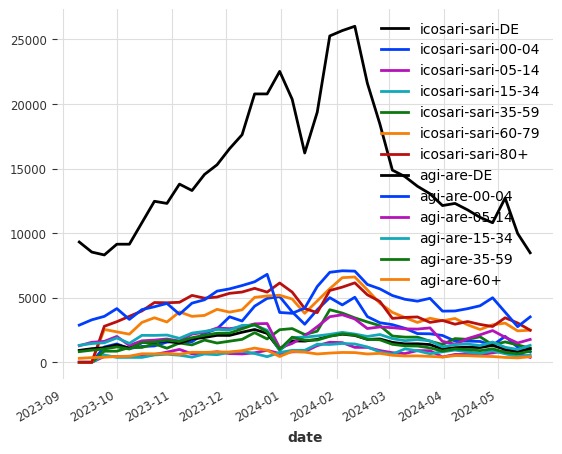

In [359]:
target_series.plot()
covariates.plot()

In [360]:
# covariates = covariates if use_covariates else None

In [361]:
ts_nowcast = load_nowcast(forecast_date, probabilistic=True, local=True)

In [362]:
# ts_nowcast = load_nowcast(forecast_date, probabilistic=False, local=True)

<Axes: xlabel='date'>

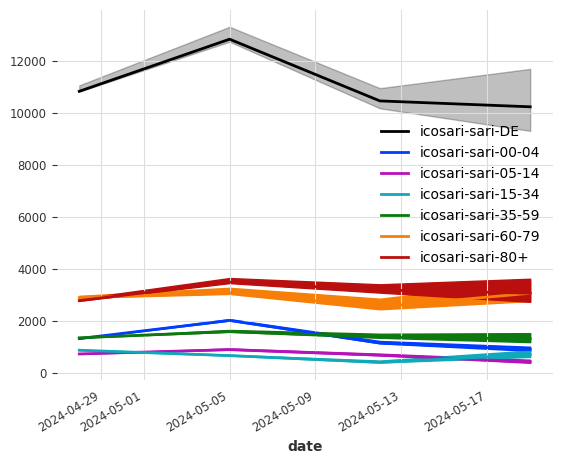

In [363]:
ts_nowcast.plot()

In [364]:
target_list = make_target_paths(target_series, ts_nowcast)

In [365]:
len(target_list)

19

In [366]:
# target_list = [target_series] * 7

In [367]:
target_list = [encode_static_covariates(t, ordinal=False) for t in target_list]

In [368]:
covariates = [covariates]*len(target_list) if covariates else None

In [369]:
name = 'tsmixer2'

In [370]:
test_year = 2019

In [371]:
model_path = f'../models/pre-covid/{name}-{test_year}-1.pt'
model = TSMixerModel.load(model_path)

In [372]:
model

TSMixerModel(output_chunk_shift=0, hidden_size=16, ff_size=16, num_blocks=4, activation=ReLU, dropout=0.2, norm_type=TimeBatchNorm2d, normalize_before=False, use_static_covariates=False, n_epochs=500, batch_size=8, optimizer_kwargs={'lr': 0.01, 'weight_decay': 0.0001}, input_chunk_length=8, optimizer_cls=<class 'torch.optim.adamw.AdamW'>, add_encoders={'datetime_attribute': {'future': ['month', 'weekofyear']}}, output_chunk_length=4, likelihood=NegativeBinomialLikelihood(), pl_trainer_kwargs={'enable_progress_bar': True, 'enable_model_summary': False, 'accelerator': 'cpu', 'callbacks': [<pytorch_lightning.callbacks.progress.rich_progress.RichProgressBar object at 0x7ffa3d744be0>]}, random_state=1)

In [373]:
fct = model.predict(n=4, 
                    series=target_list, 
                    past_covariates=covariates, 
                    num_samples=1000)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 0:00:07 • 0:00:00 0.42it/s

In [374]:
ts_forecast = concatenate(fct, axis='sample')

In [375]:
hfc_path = f'../data/submissions/{forecast_date}-icosari-sari-DW-{name}.csv'

In [376]:
hfc_path

'../data/submissions/2024-05-23-icosari-sari-DW-tsmixer2.csv'

In [377]:
hfc = ts_forecast

In [378]:
df = reshape_hfc([hfc])

In [379]:
df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])

In [380]:
# df.to_csv(hfc_path, index=False)

In [381]:
target_sari = load_target_series('sari')

In [395]:
stratum = 'DE'

In [393]:
stratum = '15-34'

In [391]:
stratum = '80+'

<Axes: xlabel='date'>

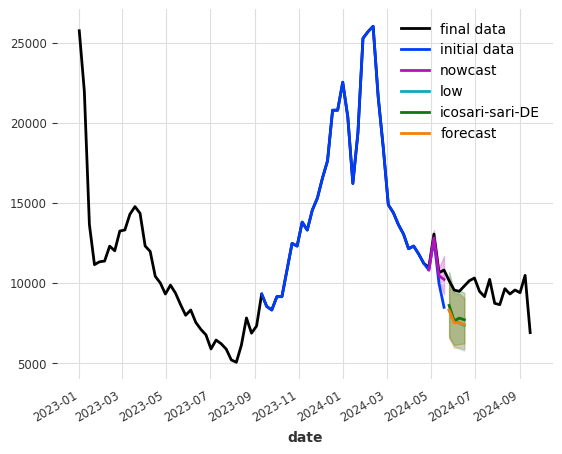

In [396]:
target_sari[f'icosari-sari-{stratum}'].plot(label='final data')
target_series[f'icosari-sari-{stratum}'].plot(label='initial data')
ts_nowcast[f'icosari-sari-{stratum}'].plot(label='nowcast')
fct[0][f'icosari-sari-{stratum}'].plot(label='low')
fct[-1][f'icosari-sari-{stratum}'].plot()
hfc[f'icosari-sari-{stratum}'].plot(label='forecast')

<Axes: xlabel='date'>

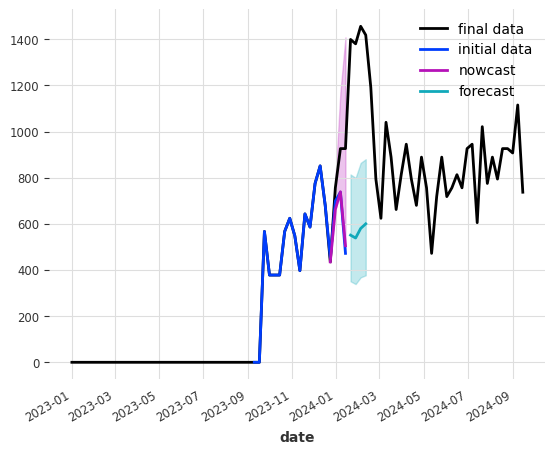

In [355]:
target_sari[f'icosari-sari-{stratum}'].plot(label='final data')
target_series[f'icosari-sari-{stratum}'].plot(label='initial data')
ts_nowcast[f'icosari-sari-{stratum}'].plot(label='nowcast')
hfc[f'icosari-sari-{stratum}'].plot(label='forecast')

<Axes: xlabel='date'>

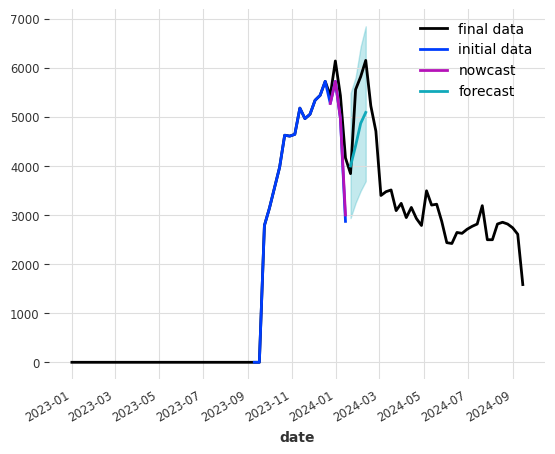

In [327]:
target_sari[f'icosari-sari-{stratum}'].plot(label='final data')
target_series[f'icosari-sari-{stratum}'].plot(label='initial data')
ts_nowcast[f'icosari-sari-{stratum}'].plot(label='nowcast')
hfc[f'icosari-sari-{stratum}'].plot(label='forecast')

<Axes: xlabel='date'>

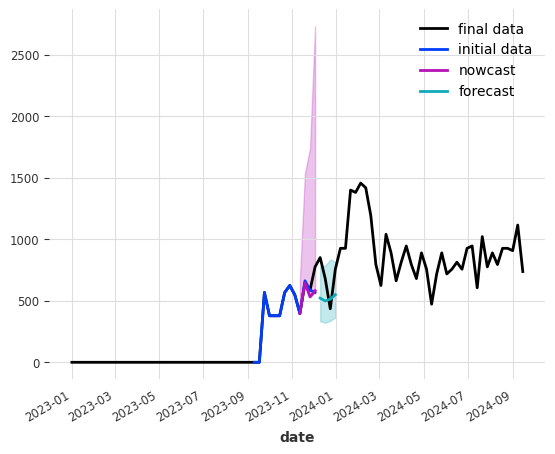

In [297]:
target_sari[f'icosari-sari-{stratum}'].plot(label='final data')
target_series[f'icosari-sari-{stratum}'].plot(label='initial data')
ts_nowcast[f'icosari-sari-{stratum}'].plot(label='nowcast')
hfc[f'icosari-sari-{stratum}'].plot(label='forecast')

<Axes: xlabel='date'>

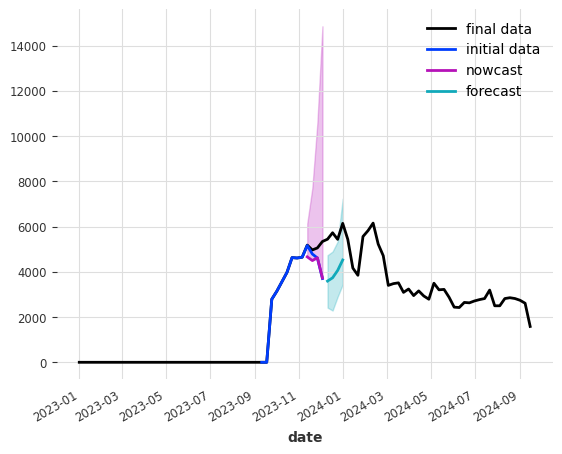

In [231]:
target_sari[f'icosari-sari-{stratum}'].plot(label='final data')
target_series[f'icosari-sari-{stratum}'].plot(label='initial data')
ts_nowcast[f'icosari-sari-{stratum}'].plot(label='nowcast')
hfc[f'icosari-sari-{stratum}'].plot(label='forecast')

In [86]:
target_sari = load_target_series('sari')

In [108]:
df_plot = prepare_plot_data(df, target_sari)

In [110]:
df_plot = prepare_plot_data(df, ts_sari)

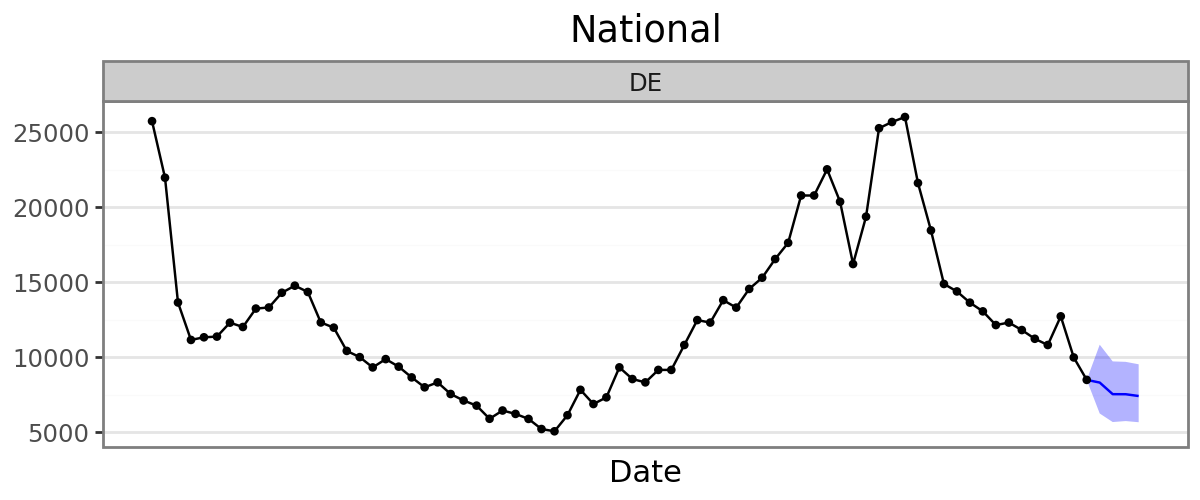

In [111]:
plot_forecasts(df_plot, 'national', start=0)

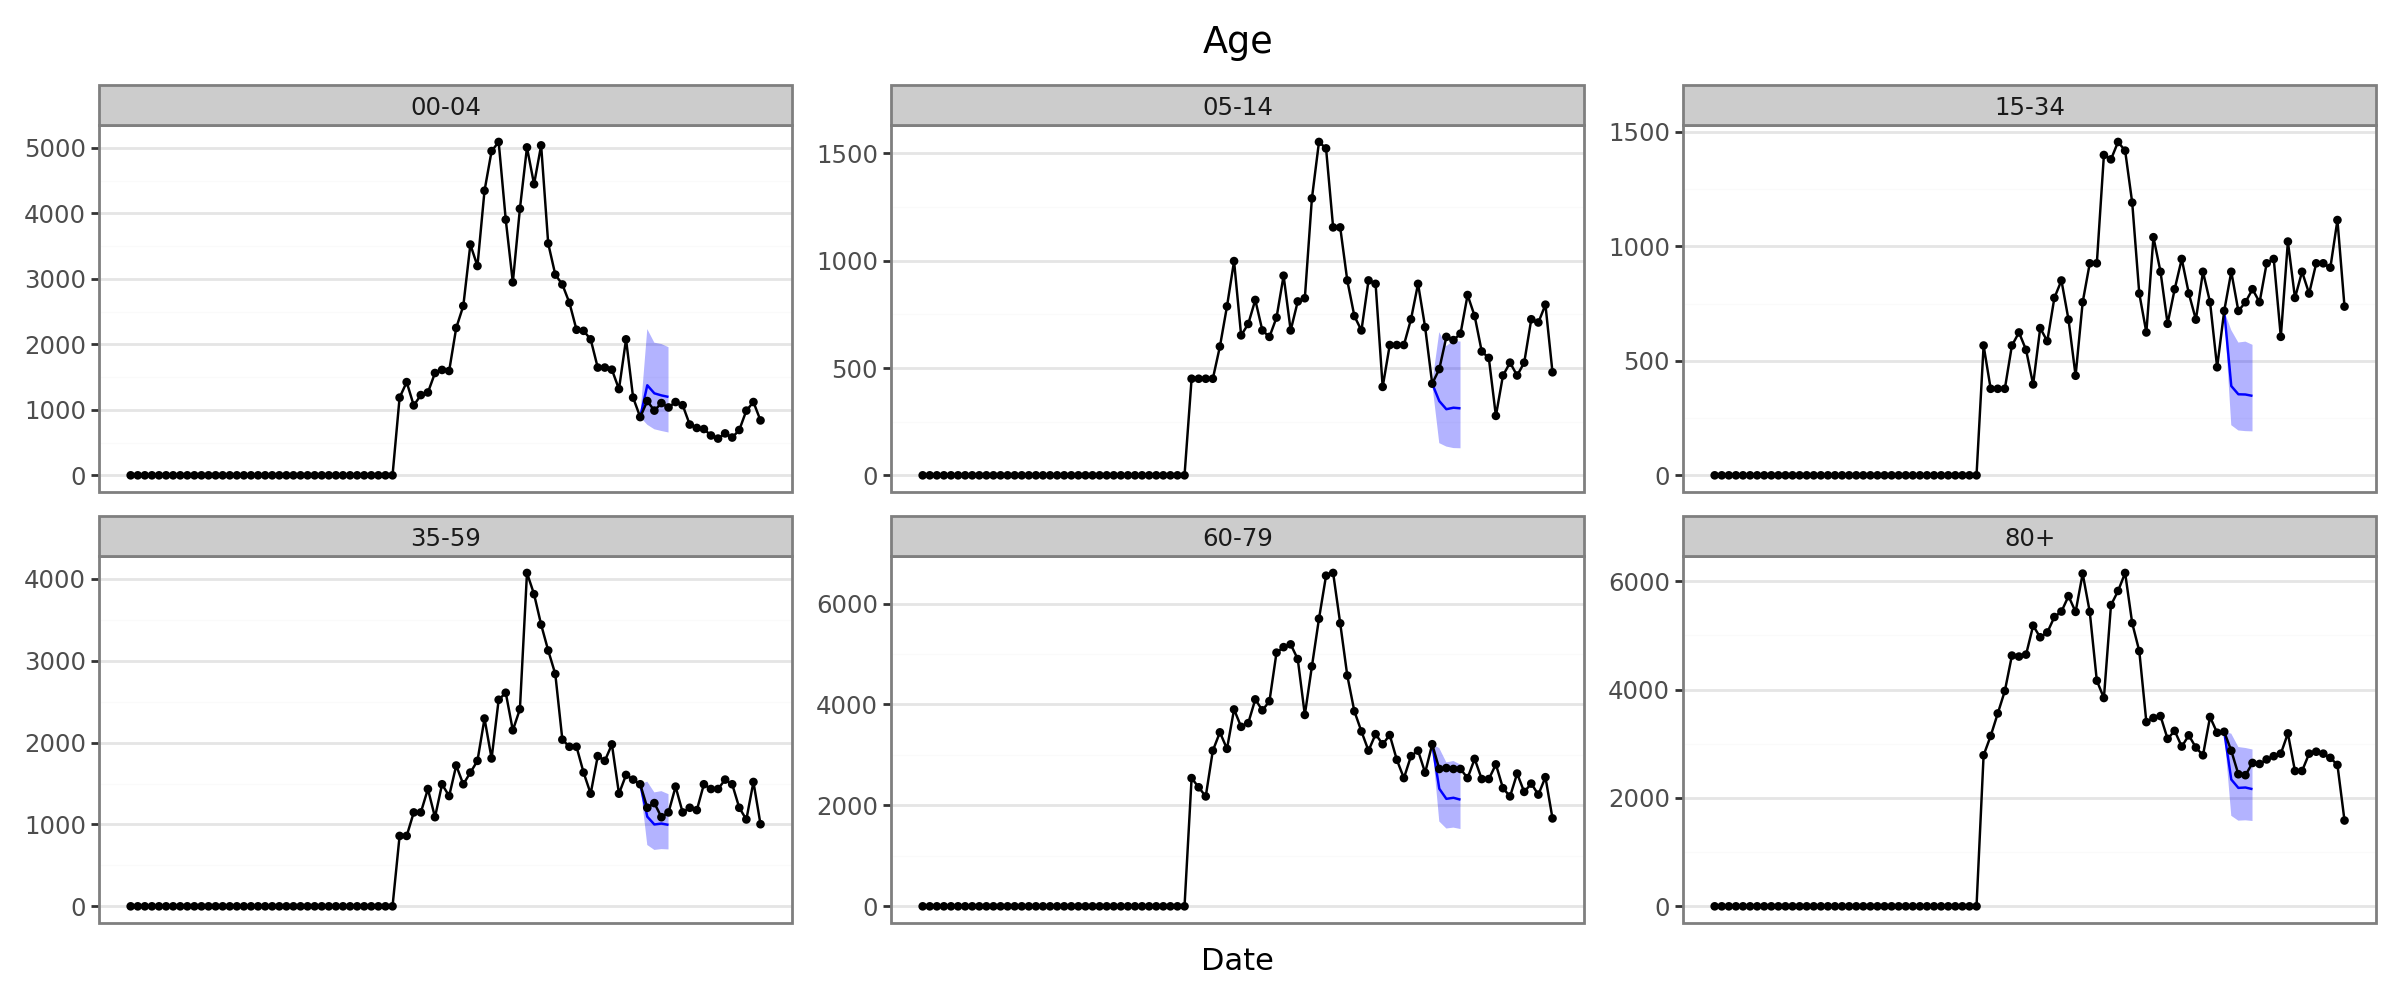

In [99]:
plot_forecasts(df_plot, 'age', start=0)

In [24]:
hfc = compute_forecast(model, target_series, covariates, forecast_date, HORIZON, NUM_SAMPLES, probabilistic_nowcast=False)

AttributeError: 'list' object has no attribute 'freq'

In [23]:
def compute_forecast(model, target_series, covariates, forecast_date, horizon, num_samples, probabilistic_nowcast=True, local=False):
    '''
    For every sample path given by the nowcasted quantiles, a probabilistic forecast is computed.
    These are then aggregated into one forecast by combining all predicted paths.
    '''
    ts_nowcast = load_nowcast(forecast_date, probabilistic_nowcast, local)
    target_list = make_target_paths(target_series, ts_nowcast)
    target_list = [encode_static_covariates(t, ordinal=False) for t in target_list]
     
    covariates = [covariates]*len(target_list) if covariates else None
      
    fct = model.predict(n=horizon, 
                        series=target_list, 
                        past_covariates=covariates, 
                        num_samples=num_samples)
      
    ts_forecast = concatenate(fct, axis='sample')
    
    return ts_forecast

In [18]:
RANDOM_SEEDS = [1, 2, 3, 4, 5] # , 6, 7, 8, 9, 10]

In [ ]:
dfs = []
for seed in RANDOM_SEEDS:
    print(seed)
    model_path = f'../models/pre-covid/{name}-{test_year}-{seed}.pt'
    model = TSMixerModel.load(model_path)
    
    hfc = compute_forecast(model, target_series, covariates, forecast_date, HORIZON, NUM_SAMPLES, probabilistic_nowcast=False)
    
    df = reshape_hfc(hfc)
    dfs.append(df)

In [ ]:
df = pd.concat(dfs)
df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

In [ ]:
df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])

In [27]:
df.to_csv(f'../data/submissions/{forecast_date}-icosari-sari-DW-{name}.csv', index=False)

# Plot forecasts

In [42]:
df_plot = prepare_plot_data(df, targets_validation[validation_start : ])

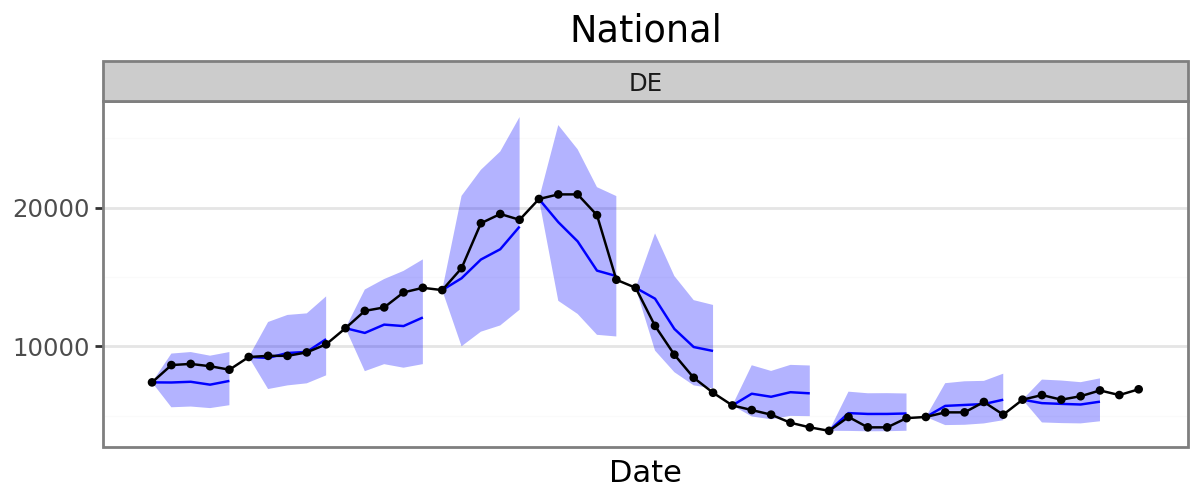

In [35]:
plot_forecasts(df_plot, 'national', start=1)

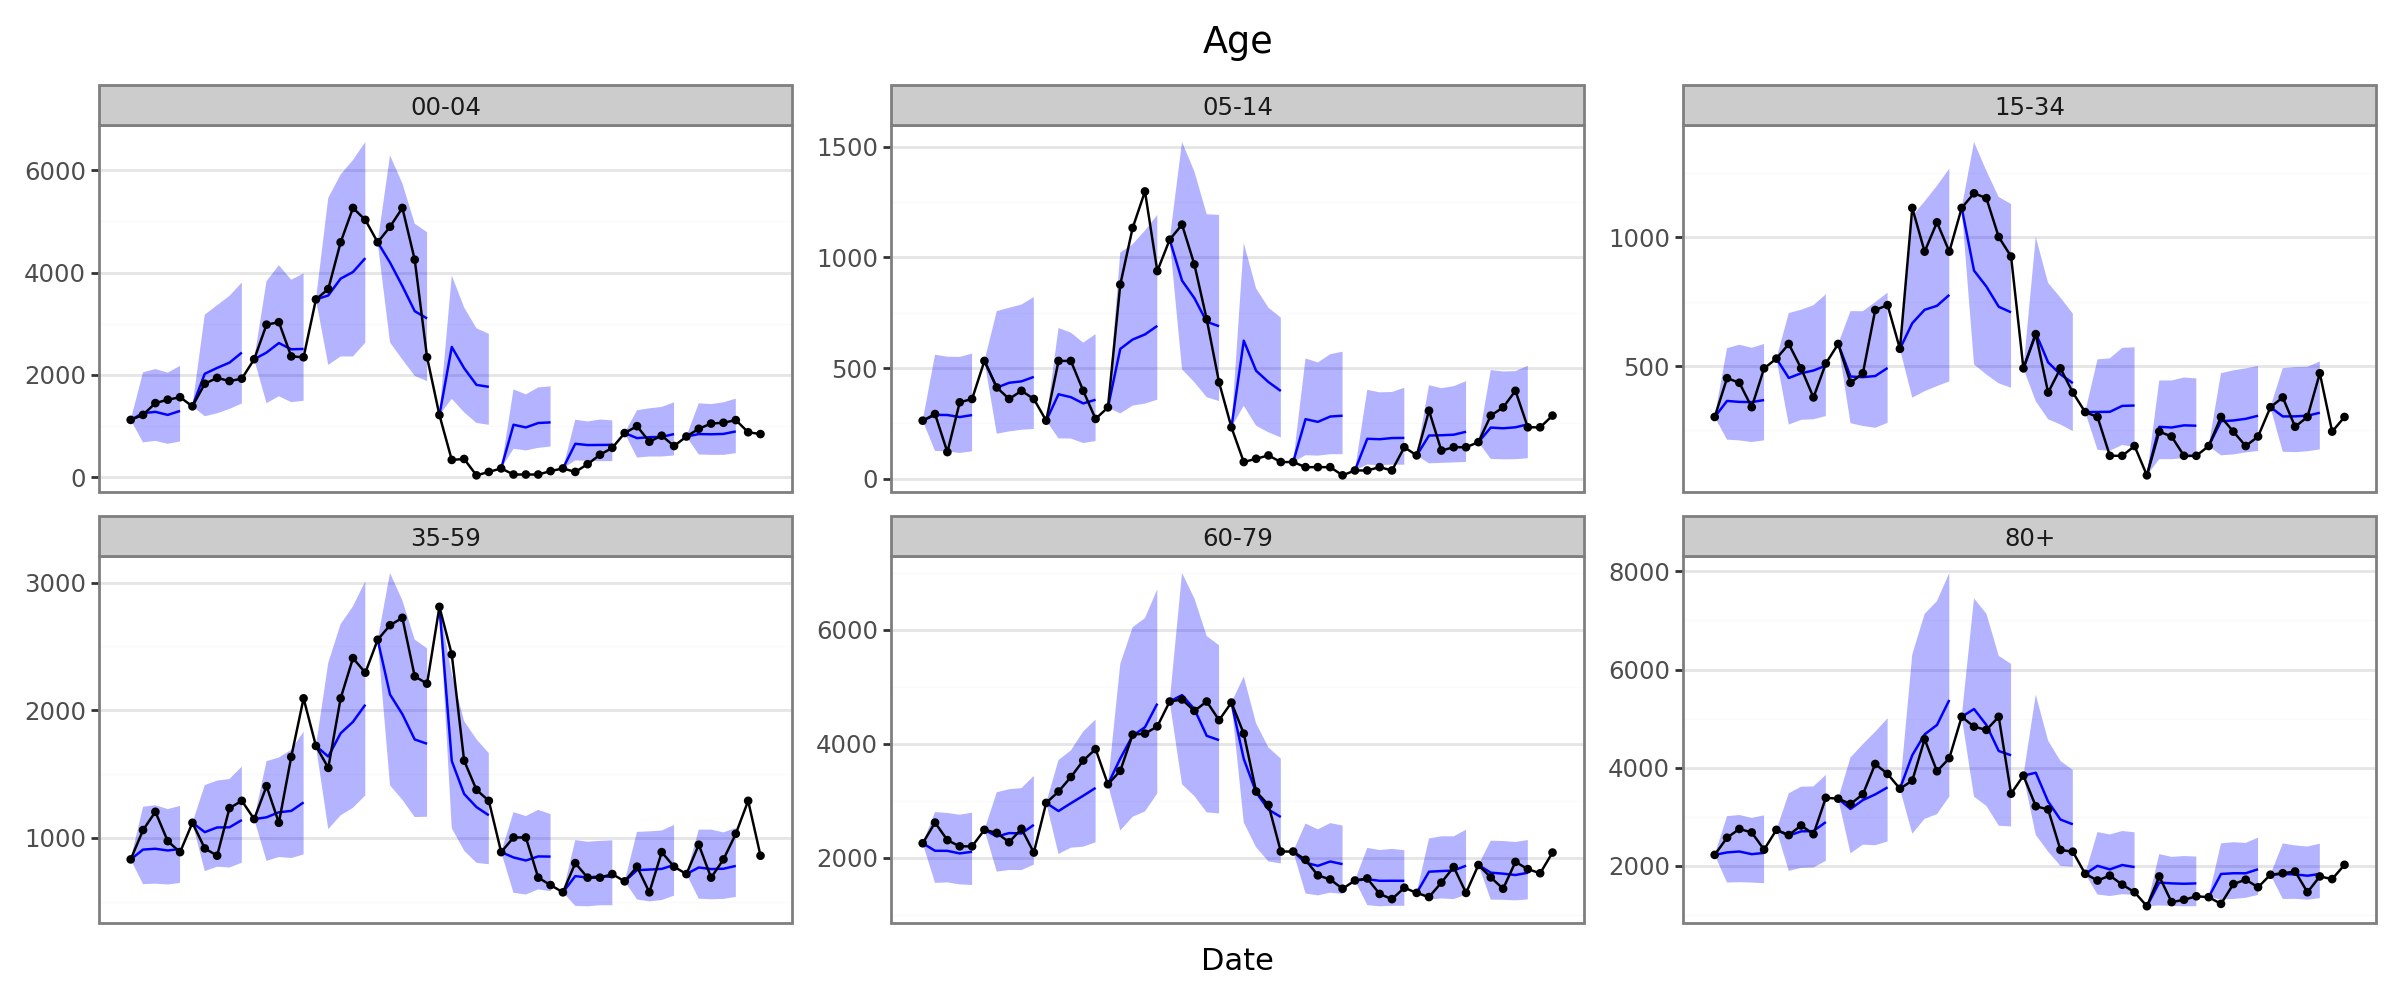

In [36]:
plot_forecasts(df_plot, 'age', start=1)